In [7]:
import kagglehub
import re
import string 
import contractions
import numpy as np
import pandas as pd
import nltk 
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt_tab')
warnings.filterwarnings("ignore")
stop_words = get_stop_words('en')

c:\Users\annag\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\annag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# EDA

In [8]:
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

train = pd.read_csv(path + '\\twitter_training.csv')
val = pd.read_csv(path + '\\twitter_validation.csv')

train.columns = ['id', 'entity', 'sentiment', 'tweet']
val.columns = ['id', 'entity', 'sentiment', 'tweet']

train.head()

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [3]:
# check number of nulls in each column
train[['id', 'entity', 'sentiment', 'tweet']].isnull().sum()

id             0
entity         0
sentiment      0
tweet        686
dtype: int64

In [5]:
val[['id', 'entity', 'sentiment', 'tweet']].isnull().sum()

id           0
entity       0
sentiment    0
tweet        0
dtype: int64

In [9]:
train.dropna(subset=['tweet'], inplace=True)

In [10]:
def draw_plot(df, name):
    """Print distribution plot of sentiment"""
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue', 'orange']
    df['sentiment'].value_counts().plot(kind='bar', color=colors)

    # sns.countplot(x='Sentiment', data=df, palette='viridis', order=sentiment_counts.index)
    plt.title(f'Distribution of sentiment ({name} set)')
    plt.ylabel('Count')
    plt.xlabel('Sentiment')
    plt.show()

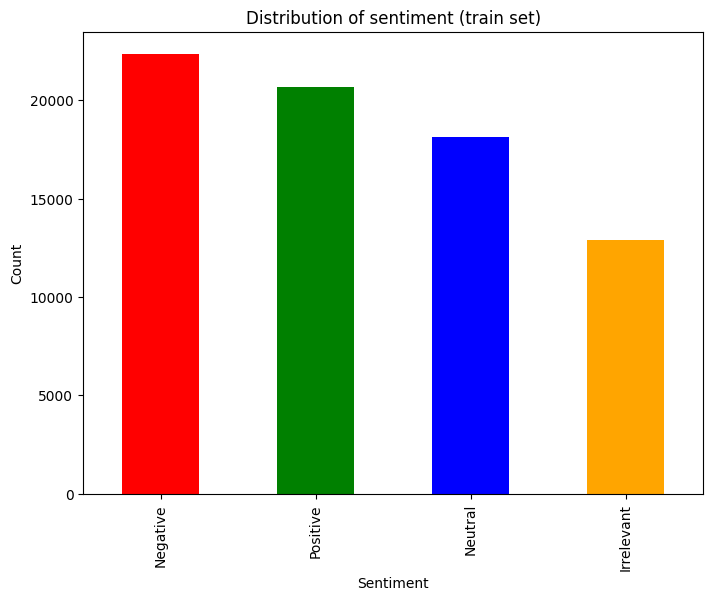

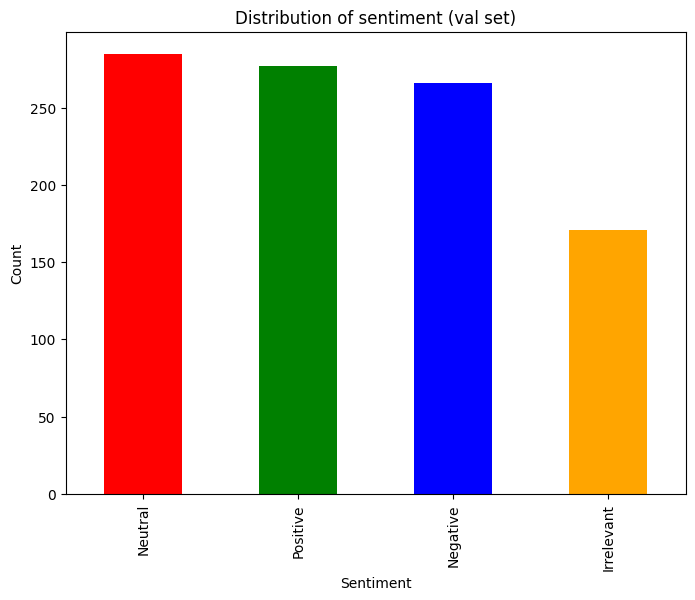

In [8]:
draw_plot(train, 'train')
draw_plot(val, 'val')

In [11]:
def clean_text(text):
    """
    Clean input text by lowercasing and removing punctuation.
    """
    # lower case
    text = text.lower() 
    # remove links
    text = re.compile(r"https?://\S+|www\.\S+").sub("", text)
    # remove punctuations
    table = str.maketrans('','',string.punctuation)
    text = text.translate(table)
    # remove unique char
    text = re.sub(r'(?:^| )\w(?:$| )', ' ',text).strip()
    # contractions
    text = " ".join([contractions.fix(word) for word in text.split()])

    replacements = {
        r"'s\b": "",
        r"\s+": " ",
    }

    for replace, by in replacements.items():
        text = re.sub(replace, by, text)

    return text.strip()

In [12]:
train['tweet_clean'] = train['tweet'].apply(lambda x: clean_text(x))
val['tweet_clean'] = val['tweet'].apply(lambda x: clean_text(x))

In [13]:
def remove_stopwords(text):
    """
    Tokenize text and remove stopwords.
    """
    text = text.apply(word_tokenize)
    text = text.apply(lambda x: [word for word in x if word not in stop_words])
    return text

In [14]:
train['tweet_no_stopwords'] = remove_stopwords(train['tweet_clean'])
train['tweet_no_stopwords'] = train['tweet_no_stopwords'].apply(lambda x: ' '.join(eval(str(x))))
val['tweet_no_stopwords'] = remove_stopwords(val['tweet_clean'])
val['tweet_no_stopwords'] = val['tweet_no_stopwords'].apply(lambda x: ' '.join(eval(str(x))))

# Modelling

In [15]:
X_train = train['tweet_no_stopwords']
y_train = train['sentiment']

X_val = val['tweet_no_stopwords']
y_val = val['sentiment']

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class DataStructure:
    def __init__(self,X,typedt,y_train=y_train,y_val=y_val,X_train=X_train,shuffle=True):
        self.X = X
        self.y_train = y_train
        self.y_val = y_val
        self.typedt = typedt
        self.X_train = X_train
        self.shuffle = shuffle

    def encode_data(self):
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(self.y_train)
        y_val = label_encoder.transform(self.y_val)
        if self.typedt == "train":
            return y_train
        else:
            return y_val
    
    def get_tokenizer(self):
        tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
        tokenizer.fit_on_texts(self.X_train)
        return tokenizer
    
    def tokenize_data(self):
        X_seq = self.get_tokenizer().texts_to_sequences(self.X)
        X_pad = pad_sequences(X_seq, maxlen=50, padding='post')
        return X_pad
    
    def tensor_data(self):
        dataset = TensorDataset(torch.tensor(self.tokenize_data(), dtype=torch.long), torch.tensor(self.encode_data(), dtype=torch.long))
        dataloader = DataLoader(dataset, batch_size=64, shuffle=self.shuffle)
        return dataloader


In [18]:
structure = DataStructure(X_train,'train',shuffle=True)
dataloader_train = structure.tensor_data()
structure_val = DataStructure(X_val,'val',shuffle=False)
dataloader_val = structure_val.tensor_data()

In [ ]:
# Definindo o modelo GRU
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, vocab_size, embedding_dim):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru_forward = nn.GRU(embedding_dim, hidden_dim, num_layers = 1, bidirectional = False, bias = True, batch_first=True)
        self.gru_backward = nn.GRU(embedding_dim, hidden_dim, num_layers = 1, bidirectional = False, bias = True, batch_first=True)
        # self.fc = nn.Linear(hidden_dim, output_dim)
        # self.gelu = nn.GELU()
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        x, _ = self.gru_forward(embedded)
        x = self.gelu(x)
        x = torch.flip(x, dims=[1])
        x, _ = self.gru_backward(x)
        x = torch.flip(x, dims=[1])
        out = self.gelu(x)
        out = out[:, -1, :]  # Pegando a última saída da GRU
        #out = self.fc(out)
        return out

In [ ]:
# class BGRUModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim):
#         super(BGRUModel, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.bgru = nn.GRU(embedding_dim, hidden_size, num_layers, bidirectional=True)
#         self.fc = nn.Linear(hidden_size * 2, num_classes)

#     def forward(self, x):
#         out, _ = self.bgru(x)
#         out = self.fc(out[:, -1, :])  
#         return out

In [ ]:
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, vocab_size, embedding_dim):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = gru_out[:, -1, :]  # Pegando a última saída da GRU
        out = self.fc(gru_out)
        return out

In [46]:
vocab_size = 10000
embedding_dim = 64
hidden_dim = 128
output_dim = 4

In [47]:
model = GRUClassifier(input_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, vocab_size=vocab_size, embedding_dim=embedding_dim)
model.to(device)

GRUClassifier(
  (embedding): Embedding(10000, 64)
  (gru_forward): GRU(64, 128, batch_first=True)
  (gru_backward): GRU(64, 128, batch_first=True)
  (gelu): GELU(approximate=128)
)

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
metrics_callback = train_model(model, dataloader_train, dataloader_val, criterion, optimizer, epochs=20, patience=3, min_delta=0.001)

TypeError: gelu(): argument 'approximate' must be str, not int

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, patience=3, min_delta=0.001):
    metrics_callback = MetricsCallback()
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)  
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_preds.append(outputs.detach())
            all_train_labels.append(labels.detach())

        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                all_val_preds.append(outputs)
                all_val_labels.append(labels)

        all_train_preds = torch.cat(all_train_preds)
        all_train_labels = torch.cat(all_train_labels)
        all_val_preds = torch.cat(all_val_preds)
        all_val_labels = torch.cat(all_val_labels)

        # Atualizando as métricas ao final de cada época
        metrics_callback.update_metrics(
            epoch,
            all_train_labels.cpu().numpy(),
            all_train_preds.cpu(),
            all_val_labels.cpu().numpy(),
            all_val_preds.cpu(),
            train_loss / len(train_loader),
            val_loss / len(val_loader)
        )

        # Verificar Early Stopping com base no val_loss
        early_stopping(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Retornando as métricas ao final do treinamento para plotar
    return metrics_callback

In [1]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        # Se for a primeira época, define o melhor loss
        if self.best_loss is None:
            self.best_loss = val_loss
        # Verifica se a melhora em val_loss é significativa
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        # Se o val_loss melhorar, reseta o contador
        else:
            self.best_loss = val_loss
            self.counter = 0

In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score

class MetricsCallback:
    def __init__(self):
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []
        self.train_loss = []
        self.val_loss = []

    def update_metrics(self, epoch, y_true_train, y_pred_train, y_true_val, y_pred_val, train_loss, val_loss):
        y_pred_train = torch.argmax(y_pred_train, dim=1).cpu().numpy()
        y_pred_val = torch.argmax(y_pred_val, dim=1).cpu().numpy()

        # Calculando as métricas para o conjunto de treino
        train_acc = (y_true_train == y_pred_train).mean()
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
        train_precision = precision_score(y_true_train, y_pred_train, average='weighted')
        train_recall = recall_score(y_true_train, y_pred_train, average='weighted')

        # Calculando as métricas para o conjunto de validação
        val_acc = (y_true_val == y_pred_val).mean()
        val_f1 = f1_score(y_true_val, y_pred_val, average='weighted')
        val_precision = precision_score(y_true_val, y_pred_val, average='weighted')
        val_recall = recall_score(y_true_val, y_pred_val, average='weighted')

        # Armazenando as métricas e a perda
        self.train_accuracy.append(train_acc)
        self.val_accuracy.append(val_acc)
        self.train_f1.append(train_f1)
        self.val_f1.append(val_f1)
        self.train_precision.append(train_precision)
        self.val_precision.append(val_precision)
        self.train_recall.append(train_recall)
        self.val_recall.append(val_recall)
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)

        # Exibindo as métricas no final de cada época
        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

In [ ]:
https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
https://www.kaggle.com/code/jvrco22/twitter-sentiment-analysis-96-val-acc#Models